<a href="https://colab.research.google.com/github/psagar2/recipes/blob/main/terapixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Performance evaluation of Terapixel rendering in Cloud (Super)computing**

## Introduction

cloud computing is one of the mostrapidly rising field and one of the reason for that is expensive hardware. The prime example of that is this report and the coding of this project has been done on google colab instead of existing hardware resources.

In [108]:
pip install pandasql

SyntaxError: ignored

Importing libraries 
pandas is imported to handle the dataframes,
padasql has been imported to run some sql queries on the dataframes and
matplotlib.pyplot is used for making and plotting graphs.

In [109]:
import pandas as pd 
import pandasql as ps 
import matplotlib.pyplot as plt


In [110]:
df  = pd.read_csv('gpu.csv')
df1 = pd.read_csv('task-x-y.csv')
df2 = pd.read_csv('application-checkpoints.csv')


In [111]:
df.drop_duplicates()
df1.drop_duplicates()
df2.drop_duplicates()

,timestamp,hostname,eventName,eventType,jobId,taskId
0,2018-11-08T07:41:55.921Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b47f0263-ba1c-48a7-8d29-4bf021b72043
1,2018-11-08T07:42:29.842Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
2,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
3,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
4,2018-11-08T07:43:13.957Z,0d56a730076643d585f77e00d2d8521a00000N,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
...,...,...,...,...,...,...
660395,2018-11-08T08:30:10.296Z,0745914f4de046078517041d70b22fe700000I,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8261c0ff-03d6-48b3-a50f-da41cb3291fd
660396,2018-11-08T08:30:10.325Z,0745914f4de046078517041d70b22fe700000I,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8261c0ff-03d6-48b3-a50f-da41cb3291fd
660397,2018-11-08T08:30:14.081Z,a77ef58b13ad4c01b769dac8409af3f800000H,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,ce97e3e9-494a-43a7-aa85-edd2db4cf099
660398,2018-11-08T08:30:14.127Z,a77ef58b13ad4c01b769dac8409af3f800000H,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,ce97e3e9-494a-43a7-aa85-edd2db4cf099


In [112]:
dfsavingconfig=ps.sqldf('select * from df2 where eventName="Saving Config" ')
dftotalrender=ps.sqldf('select * from df2 where eventName="TotalRender" ')
dfrender=ps.sqldf('select * from df2 where eventName="Render" ')
dftiling=ps.sqldf('select * from df2 where eventName="Tiling" ')
dfuploading=ps.sqldf('select * from df2 where eventName="Uploading" ')

In [113]:
df.hostname.nunique()

1024

In [114]:
df2.hostname.nunique()

1024

In [115]:
df.gpuSerial.nunique()

1024

In [116]:
df.head()

,timestamp,hostname,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc
0,2018-11-08T08:27:10.314Z,8b6a0eebc87b4cb2b0539e81075191b900001C,323217055910,GPU-1d1602dc-f615-a7c7-ab53-fb4a7a479534,131.55,48,92,53
1,2018-11-08T08:27:10.192Z,d8241877cd994572b46c861e5d144c85000000,323617020295,GPU-04a2dea7-f4f1-12d0-b94d-996446746e6f,117.03,40,92,48
2,2018-11-08T08:27:10.842Z,db871cd77a544e13bc791a64a0c8ed50000006,323217056562,GPU-f4597939-a0b4-e78a-2436-12dbab9a350f,121.64,45,91,44
3,2018-11-08T08:27:10.424Z,b9a1fa7ae2f74eb68f25f607980f97d7000010,325217085931,GPU-ad773c69-c386-a4be-b214-1ea4fc6045df,50.23,38,90,43
4,2018-11-08T08:27:10.937Z,db871cd77a544e13bc791a64a0c8ed50000003,323217056464,GPU-2d4eed64-4ca8-f12c-24bc-28f036493ea2,141.82,41,90,47


In [117]:
print(df.describe())


          gpuSerial  powerDrawWatt      gpuTempC   gpuUtilPerc  gpuMemUtilPerc
count  1.543681e+06   1.543681e+06  1.543681e+06  1.543681e+06    1.543681e+06
mean   3.239836e+11   8.919838e+01  4.007560e+01  6.305820e+01    3.341359e+01
std    1.228841e+09   3.975742e+01  3.800243e+00  4.144816e+01    2.300107e+01
min    3.201181e+11   2.255000e+01  2.600000e+01  0.000000e+00    0.000000e+00
25%    3.236170e+11   4.499000e+01  3.800000e+01  0.000000e+00    0.000000e+00
50%    3.236170e+11   9.659000e+01  4.000000e+01  8.900000e+01    4.300000e+01
75%    3.250170e+11   1.213400e+02  4.200000e+01  9.200000e+01    5.100000e+01
max    3.252171e+11   1.970100e+02  5.500000e+01  1.000000e+02    8.300000e+01


In [118]:
df1.head()

,taskId,jobId,x,y,level
0,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12
1,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12
2,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12
3,000993b6-fc88-489d-a4ca-0a44fd800bd3,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,235,11,12
4,000b158b-0ba3-4dca-bf5b-1b3bd5c28207,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,171,53,12


In [119]:
print(df1.describe())

                  x             y         level
count  65793.000000  65793.000000  65793.000000
mean     127.031143    127.031143     11.984314
std       74.135963     74.135963      0.250965
min        0.000000      0.000000      4.000000
25%       63.000000     63.000000     12.000000
50%      127.000000    127.000000     12.000000
75%      191.000000    191.000000     12.000000
max      255.000000    255.000000     12.000000


In [120]:
df2.head()

,timestamp,hostname,eventName,eventType,jobId,taskId
0,2018-11-08T07:41:55.921Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b47f0263-ba1c-48a7-8d29-4bf021b72043
1,2018-11-08T07:42:29.842Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
2,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
3,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
4,2018-11-08T07:43:13.957Z,0d56a730076643d585f77e00d2d8521a00000N,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d


In [121]:
print(df2.describe())

                       timestamp  ...                                taskId
count                     660400  ...                                660400
unique                    363555  ...                                 65793
top     2018-11-08T07:41:31.776Z  ...  7712251e-80a5-4310-bb68-b497088d9101
freq                          18  ...                                    20

[4 rows x 6 columns]


In [122]:
df3 = pd.merge(df, df2, on = ["timestamp"])

In [196]:
df3.head()

,timestamp,hostname_x,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,hostname_y,eventName,eventType,jobId,taskId
0,2018-11-08T08:27:10.875Z,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af
1,2018-11-08T08:27:10.875Z,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af
2,2018-11-08T08:27:10.624Z,b9a1fa7ae2f74eb68f25f607980f97d700000B,324917052053,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc
3,2018-11-08T08:27:10.624Z,b9a1fa7ae2f74eb68f25f607980f97d700000B,324917052053,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc
4,2018-11-08T08:27:10.359Z,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc


In [124]:
df3start=df3[(df3['eventType']=='START')]
df3stop=df3[(df3['eventType']=='STOP')]

In [125]:
df3merge=pd.merge(df3start,df3stop,on=['taskId','eventName'])

In [126]:
df3merge['timestamp_x']=pd.to_datetime(df3merge['timestamp_x'])
df3merge['timestamp_y']=pd.to_datetime(df3merge['timestamp_y'])

In [127]:
df3merge['timestamp_x'].dtype
df3merge['timestamp_y'].dtype

datetime64[ns, UTC]

In [128]:
df3merge['timediff']=df3merge['timestamp_y']-df3merge['timestamp_x']

In [129]:
df3merge['timediff']=(df3merge['timediff'].dt.total_seconds())

In [130]:
df3merge['timediff']

0         1.121
1        46.741
2         1.032
3         1.032
4        47.483
          ...  
86628    48.771
86629    23.929
86630     0.972
86631     0.002
86632     0.002
Name: timediff, Length: 86633, dtype: float64

In [131]:
df3merge.head()

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,hostname_y_x,eventName,eventType_x,jobId_x,taskId,timestamp_y,hostname_x_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,hostname_y_y,eventType_y,jobId_y,timediff
0,2018-11-08 08:27:10.875000+00:00,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af,2018-11-08 08:27:11.996000+00:00,95b4ae6d890e4c46986d91d7ac4bf08200000T,324917052614,GPU-bc05182a-0194-740f-827e-851d9ae28136,40.97,35,0,0,265232c5f6814768aeefa66a7bec6ff6000010,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.121
1,2018-11-08 08:27:10.624000+00:00,b9a1fa7ae2f74eb68f25f607980f97d700000B,324917052053,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc,2018-11-08 08:27:57.365000+00:00,4c72fae95b9147189a0559269a6953ff00000P,325117172543,GPU-159afbfa-9b2e-ec8c-aff4-a920bd54b8ba,43.79,37,0,0,04dc4e9647154250beeee51b866b0715000014,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46.741
2,2018-11-08 08:27:10.359000+00:00,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,2018-11-08 08:27:11.391000+00:00,04dc4e9647154250beeee51b866b071500001C,323617020155,GPU-51b7ec74-a5ac-06b7-1fd0-9c11ce579ffc,28.05,39,0,0,6139a35676de44d6b61ec247f0ed8657000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.032
3,2018-11-08 08:27:10.359000+00:00,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,2018-11-08 08:27:11.391000+00:00,b9a1fa7ae2f74eb68f25f607980f97d7000012,325117172395,GPU-50f23433-71f3-6f16-3c86-0de884dc7493,44.21,37,0,0,6139a35676de44d6b61ec247f0ed8657000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.032
4,2018-11-08 08:27:10.678000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0,2018-11-08 08:27:58.161000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700000H,323617043161,GPU-82ba6a59-510a-9995-4167-0945785066b3,27.05,35,0,0,6139a35676de44d6b61ec247f0ed865700001D,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,47.483


In [132]:
df4=pd.merge(df3merge,df1,on=['taskId'])

In [194]:
df4.head()

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,hostname_y_x,eventName,eventType_x,jobId_x,taskId,timestamp_y,hostname_x_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,hostname_y_y,eventType_y,jobId_y,timediff,jobId,x,y,level
0,2018-11-08 08:27:10.875000+00:00,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af,2018-11-08 08:27:11.996000+00:00,95b4ae6d890e4c46986d91d7ac4bf08200000T,324917052614,GPU-bc05182a-0194-740f-827e-851d9ae28136,40.97,35,0,0,265232c5f6814768aeefa66a7bec6ff6000010,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.121,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,32,174,12
1,2018-11-08 08:27:10.624000+00:00,b9a1fa7ae2f74eb68f25f607980f97d700000B,324917052053,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc,2018-11-08 08:27:57.365000+00:00,4c72fae95b9147189a0559269a6953ff00000P,325117172543,GPU-159afbfa-9b2e-ec8c-aff4-a920bd54b8ba,43.79,37,0,0,04dc4e9647154250beeee51b866b0715000014,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46.741,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,167,224,12
2,2018-11-08 08:27:57.365000+00:00,4c72fae95b9147189a0559269a6953ff00000P,325117172543,GPU-159afbfa-9b2e-ec8c-aff4-a920bd54b8ba,43.79,37,0,0,04dc4e9647154250beeee51b866b0715000014,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc,2018-11-08 08:27:58.370000+00:00,6139a35676de44d6b61ec247f0ed865700000P,325117063654,GPU-9abdbeab-aad4-4016-7129-099b8044c045,111.96,42,91,47,04dc4e9647154250beeee51b866b0715000014,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.005,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,167,224,12
3,2018-11-08 08:27:10.359000+00:00,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,2018-11-08 08:27:11.391000+00:00,04dc4e9647154250beeee51b866b071500001C,323617020155,GPU-51b7ec74-a5ac-06b7-1fd0-9c11ce579ffc,28.05,39,0,0,6139a35676de44d6b61ec247f0ed8657000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.032,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,248,255,12
4,2018-11-08 08:27:10.359000+00:00,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,2018-11-08 08:27:11.391000+00:00,b9a1fa7ae2f74eb68f25f607980f97d7000012,325117172395,GPU-50f23433-71f3-6f16-3c86-0de884dc7493,44.21,37,0,0,6139a35676de44d6b61ec247f0ed8657000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.032,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,248,255,12


In [134]:
df5=df4.drop(columns=['timestamp_x','timestamp_y','hostname_x_x','hostname_x_y','gpuSerial_y', 'gpuUUID_y', 'powerDrawWatt_y','gpuTempC_y', 'gpuUtilPerc_y', 'gpuMemUtilPerc_y','hostname_y_y', 'eventType_y', 'jobId_y', 'gpuUUID_x','jobId_x','hostname_y_x', 'gpuSerial_x','eventType_x' ])

In [135]:
df5

,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,eventName,taskId,timediff,jobId,x,y,level
0,77.87,36,90,40,Uploading,0fea60cb-e10d-4879-a50d-9c20926f50af,1.121,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,32,174,12
1,88.47,40,91,48,Render,46496dde-fa77-4395-8cda-8705561b32dc,46.741,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,167,224,12
2,43.79,37,0,0,Uploading,46496dde-fa77-4395-8cda-8705561b32dc,1.005,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,167,224,12
3,146.32,43,93,52,Uploading,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,1.032,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,248,255,12
4,146.32,43,93,52,Uploading,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,1.032,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,248,255,12
...,...,...,...,...,...,...,...,...,...,...,...
86628,114.35,41,91,54,TotalRender,7c67641a-56ca-4ca7-a51e-789b33f1baed,43.016,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,5,159,12
86629,114.35,41,91,54,Saving Config,7c67641a-56ca-4ca7-a51e-789b33f1baed,0.003,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,5,159,12
86630,48.19,45,0,0,Tiling,6bc43df5-f37a-42bc-803b-f9758d935b71,1.018,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,74,151,12
86631,48.19,45,0,0,Tiling,6bc43df5-f37a-42bc-803b-f9758d935b71,1.018,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,74,151,12


In [136]:
eventtime=ps.sqldf('select eventName, sum(timediff) as total_time  from df3merge  where NOT eventName="TotalRender" group by eventName')

In [137]:
eventtime

,eventName,total_time
0,Render,703087.665
1,Saving Config,43.142
2,Tiling,16727.443
3,Uploading,23927.232


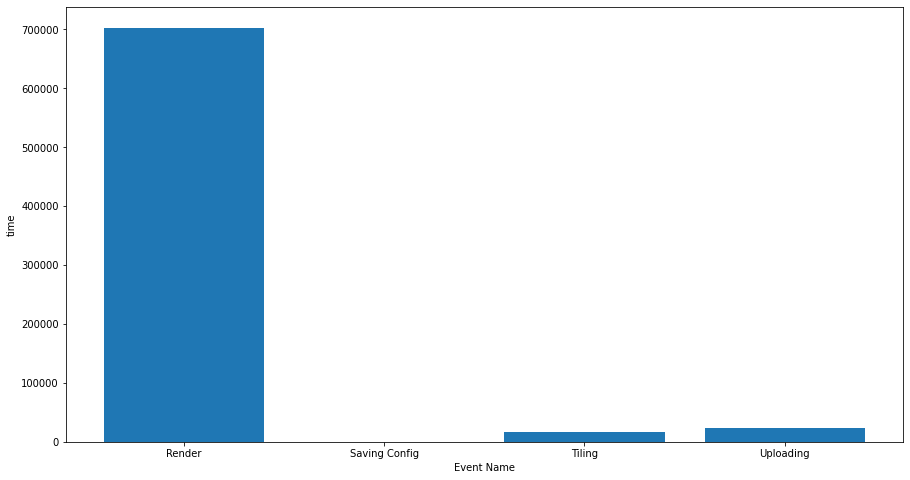

In [138]:
plt.bar(eventtime.eventName,eventtime.total_time )
plt.ylabel('time')
plt.xlabel('Event Name')
plt.rcParams['figure.figsize']=[15,8]

Gpu execution time is majorly dominated by Render as compared to tiling and uploading. therefore utilization of gpu should be in a way that most heavy task should be alloted the most powerfull GPU. so that the running cost can be kept low. so the task runtimes are majorly dominated by render.

0.5059063290736544


Text(0, 0.5, 'Temperature in celsius')

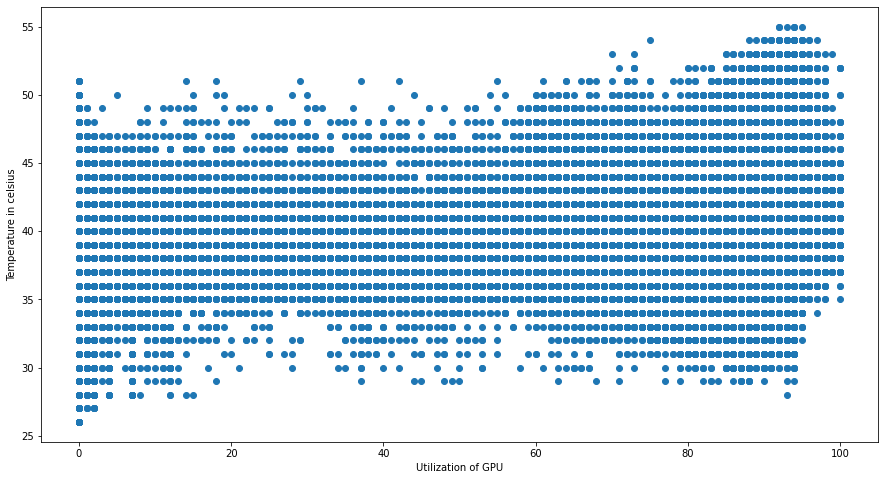

In [139]:
x=df.gpuUtilPerc
y=df.gpuTempC
print(x.corr(y))
plt.scatter(df.gpuUtilPerc,df.gpuTempC)
plt.xlabel("Utilization of GPU")
plt.ylabel("Temperature in celsius")

As it can be observed that correlation between temperature and utilization is about 0.5 and the graph depicts that high temperatures are achieved even when the gpu performence is low. hence there is no direct relation between these.
Moreover the cooling system is suggested to be used at all times and there running cost should be considered as an important cost compounding factor.

0.49278284152600066


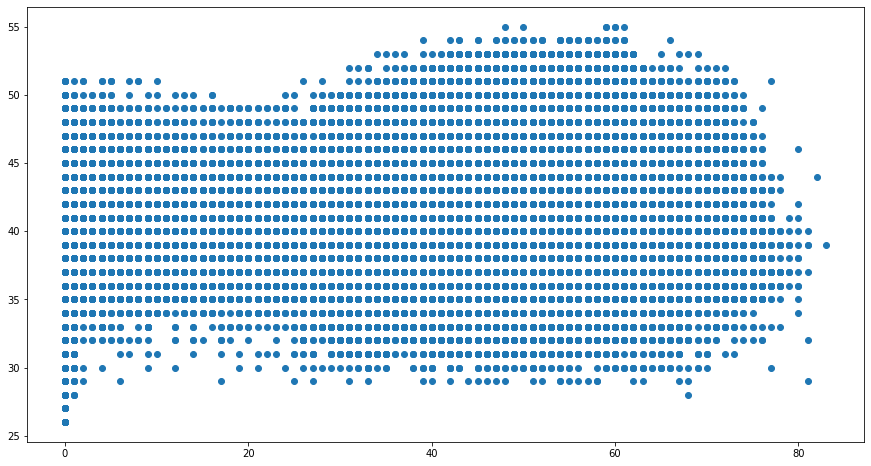

In [140]:
x=df.gpuMemUtilPerc
y=df.gpuTempC
print(x.corr(y))
plt.scatter(x,y)

0.5371909890230221


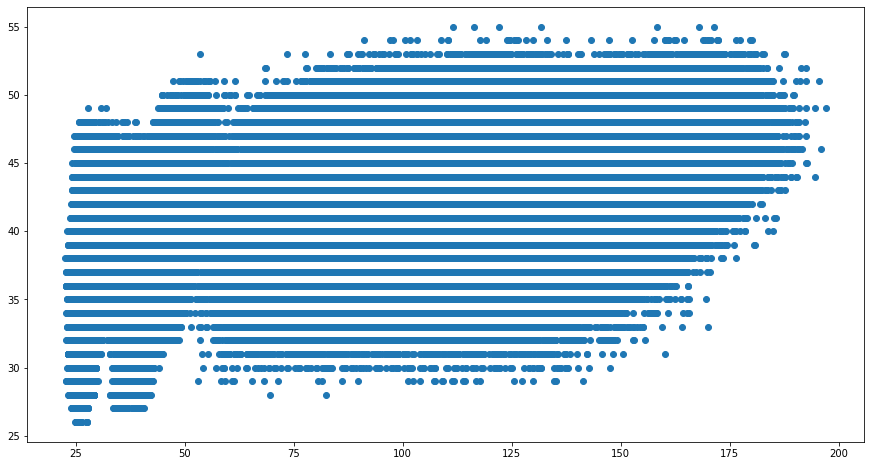

In [197]:
x=df.powerDrawWatt
y=df.gpuTempC
print(x.corr(y))
plt.scatter(x,y)

In [191]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

0.8707451224651878


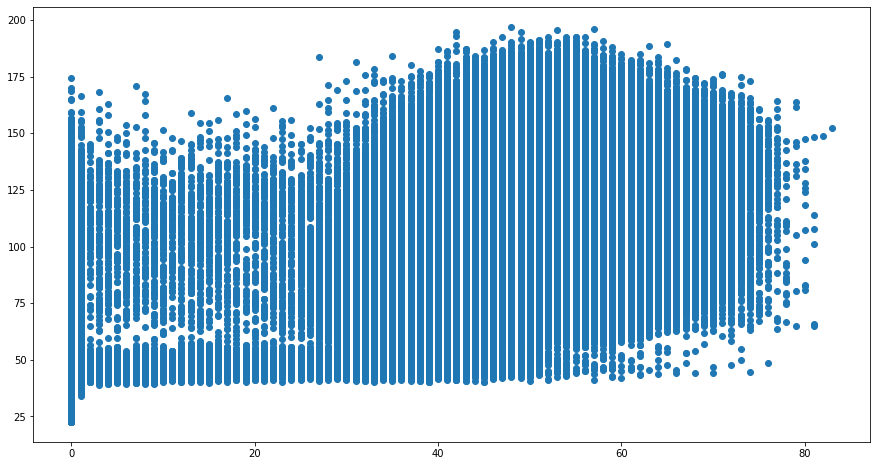

In [142]:
x=df.gpuMemUtilPerc
y=df.powerDrawWatt
print(x.corr(y))
plt.scatter(x,y)

0.8626730321864096


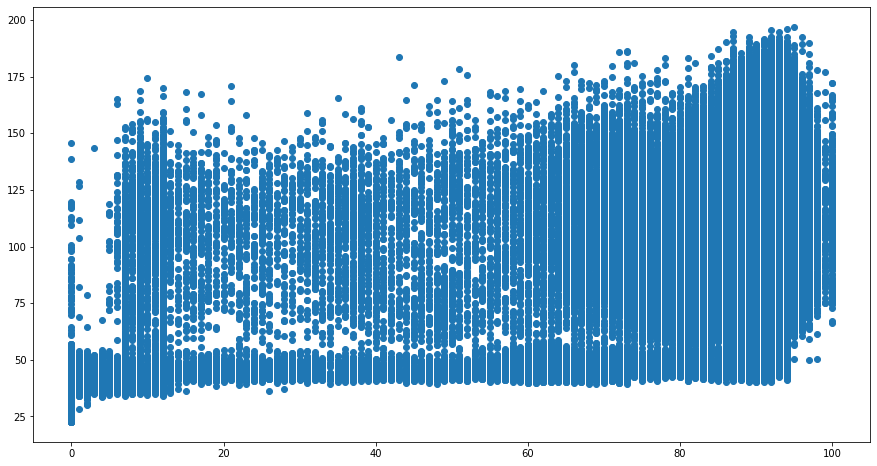

In [143]:
x=df.gpuUtilPerc
y=df.powerDrawWatt
print(x.corr(y))
plt.scatter(x,y)

0.9665710683356831


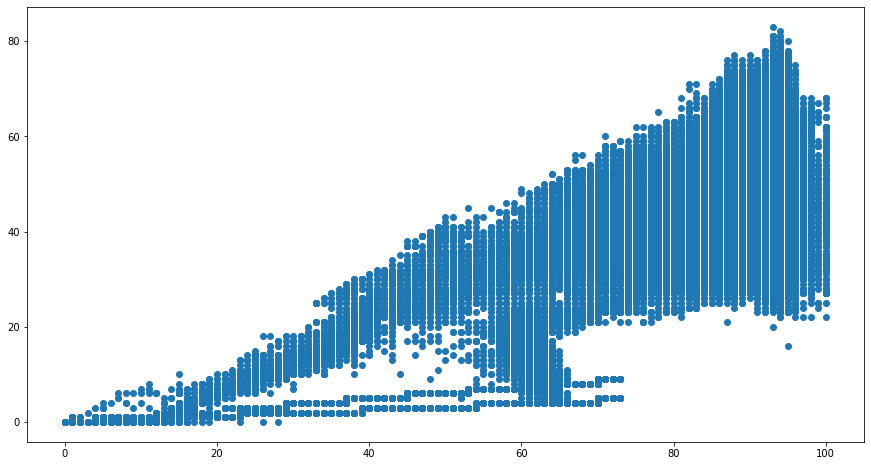

In [144]:
x=df.gpuUtilPerc
y=df.gpuMemUtilPerc
print(x.corr(y))
plt.scatter(x,y)

In [145]:
dftotalrender=ps.sqldf('select * from df3 where eventName="TotalRender" ')
dftotalrender

,timestamp,hostname_x,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,hostname_y,eventName,eventType,jobId,taskId
0,2018-11-08T08:27:10.574Z,a77ef58b13ad4c01b769dac8409af3f800000Y,323617020164,GPU-d480204b-d0c9-1631-fd55-7ae42e6470cf,141.29,41,94,58,83ea61ac1ef54f27a3bf7bd0f41ecaa700000C,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c2e827e9-de83-452f-abf2-cc50d4293a3b
1,2018-11-08T08:27:10.574Z,a77ef58b13ad4c01b769dac8409af3f800000Y,323617020164,GPU-d480204b-d0c9-1631-fd55-7ae42e6470cf,141.29,41,94,58,db871cd77a544e13bc791a64a0c8ed50000010,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8a8e3266-68dd-4ef1-b99a-b3e88ec9a970
2,2018-11-08T08:27:07.808Z,265232c5f6814768aeefa66a7bec6ff600000A,323617042839,GPU-0a470a0d-0f60-58d8-7e32-be9c1b4f828c,47.64,37,0,0,b9a1fa7ae2f74eb68f25f607980f97d700000H,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,76fe1add-66f8-4d52-aba3-750d07d9ff85
3,2018-11-08T08:27:07.808Z,cd44f5819eba427a816e7ce648adceb200000Z,323617042746,GPU-dbbe4b2d-299a-0324-b56a-3a1cef0df006,134.50,41,93,53,b9a1fa7ae2f74eb68f25f607980f97d700000H,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,76fe1add-66f8-4d52-aba3-750d07d9ff85
4,2018-11-08T08:27:13.475Z,265232c5f6814768aeefa66a7bec6ff600000K,323617020110,GPU-5f50560e-c1d9-4cdc-8076-02a03a4c8832,124.88,43,93,52,e7adc42d28814e518e9601ac2329c513000002,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,59f756d6-2e27-4c33-b44e-28aac785da46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67751,2018-11-08T08:04:32.992Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,28.22,36,0,0,0d56a730076643d585f77e00d2d8521a00000T,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b86620b9-93aa-4ae2-8d97-d68b1bac8d16
67752,2018-11-08T08:05:49.714Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,97.68,41,91,57,b9a1fa7ae2f74eb68f25f607980f97d7000011,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,d6474694-3e5f-4767-971e-c4e9d9c69d56
67753,2018-11-08T08:05:49.714Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,97.68,41,91,57,04dc4e9647154250beeee51b866b0715000014,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8b8faa57-c9ec-4eb0-99b9-9bd6ef77e074
67754,2018-11-08T08:05:55.765Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,109.46,41,92,54,4ad946d4435c42dabb5073531ea4f315000010,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,e3fc4f9c-3ca3-4034-bfa7-3a633c1632f6


In [146]:
dftotalrender=ps.sqldf('select avg(powerDrawWatt_x),	avg(gpuTempC_x), avg(gpuUtilPerc_x),	avg(gpuMemUtilPerc_x)	 from df3merge where eventName="TotalRender" group by eventName')
dftotalrender

,avg(powerDrawWatt_x),avg(gpuTempC_x),avg(gpuUtilPerc_x),avg(gpuMemUtilPerc_x)
0,91.254808,40.319924,65.020657,34.597734


In [147]:
dfrender=ps.sqldf('select * from df3merge where eventName="Render" ')
dfrender

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,hostname_y_x,eventName,eventType_x,jobId_x,taskId,timestamp_y,hostname_x_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,hostname_y_y,eventType_y,jobId_y,timediff
0,2018-11-08 08:27:10.624000,b9a1fa7ae2f74eb68f25f607980f97d700000B,324917052053,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc,2018-11-08 08:27:57.365000,4c72fae95b9147189a0559269a6953ff00000P,325117172543,GPU-159afbfa-9b2e-ec8c-aff4-a920bd54b8ba,43.79,37,0,0,04dc4e9647154250beeee51b866b0715000014,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46.741
1,2018-11-08 08:27:10.678000,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0,2018-11-08 08:27:58.161000,83ea61ac1ef54f27a3bf7bd0f41ecaa700000H,323617043161,GPU-82ba6a59-510a-9995-4167-0945785066b3,27.05,35,0,0,6139a35676de44d6b61ec247f0ed865700001D,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,47.483
2,2018-11-08 08:27:10.678000,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0,2018-11-08 08:27:58.161000,4c72fae95b9147189a0559269a6953ff000019,325117173260,GPU-b9062074-586b-dfcc-c113-d8d71f2586c7,41.36,37,0,0,6139a35676de44d6b61ec247f0ed865700001D,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,47.483
3,2018-11-08 08:27:10.678000,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0,2018-11-08 08:27:58.161000,8b6a0eebc87b4cb2b0539e81075191b9000008,323617020979,GPU-6c575595-f894-a5cb-1eb4-bbd848ca2ea4,40.50,39,0,0,6139a35676de44d6b61ec247f0ed865700001D,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,47.483
4,2018-11-08 08:27:10.678000,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0,2018-11-08 08:27:58.161000,d8241877cd994572b46c861e5d144c85000017,323617020449,GPU-e7c85eef-7253-2919-5f20-4a6325716726,111.76,45,92,44,6139a35676de44d6b61ec247f0ed865700001D,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,47.483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17028,2018-11-08 08:28:02.700000,83ea61ac1ef54f27a3bf7bd0f41ecaa7000002,323617042707,GPU-b82d3a0a-110a-55d6-f3cf-384c6911d744,35.91,36,0,0,b9a1fa7ae2f74eb68f25f607980f97d7000010,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1d6f10c0-9ae5-4229-bd0f-3f529b55f039,2018-11-08 08:28:42.529000,dcc19f48bb3445a28338db3a8f002e9c00000A,323617042806,GPU-40714bea-b186-376e-938c-1d4c19d7ae02,127.84,41,89,39,b9a1fa7ae2f74eb68f25f607980f97d7000010,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,39.829
17029,2018-11-08 08:27:59.537000,cd44f5819eba427a816e7ce648adceb200000Q,323617021550,GPU-f6da03af-495c-37d4-e005-61d046011916,142.61,42,93,47,a77ef58b13ad4c01b769dac8409af3f800000B,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b8ca2b95-1658-45ff-9044-b9d4f836db27,2018-11-08 08:28:43.191000,95b4ae6d890e4c46986d91d7ac4bf08200000N,325217086283,GPU-e3f7475a-5907-6861-c310-9f3d86e0db9d,28.80,38,0,0,a77ef58b13ad4c01b769dac8409af3f800000B,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,43.654
17030,2018-11-08 08:27:59.537000,cd44f

In [148]:
correlation_matrix=dfrender.corr()
round(correlation_matrix,2)

,gpuSerial_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,gpuSerial_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,timediff
gpuSerial_x,1.00,-0.01,-0.16,-0.01,-0.01,0.01,0.00,0.00,-0.00,-0.00,-0.01
powerDrawWatt_x,-0.01,1.00,0.50,0.85,0.87,-0.01,0.02,0.05,0.02,0.02,0.01
gpuTempC_x,-0.16,0.50,1.00,0.46,0.45,-0.01,0.04,0.08,0.02,0.02,0.04
gpuUtilPerc_x,-0.01,0.85,0.46,1.00,0.97,-0.01,0.03,0.05,0.02,0.02,0.02
gpuMemUtilPerc_x,-0.01,0.87,0.45,0.97,1.00,-0.01,0.03,0.04,0.02,0.02,0.02
gpuSerial_y,0.01,-0.01,-0.01,-0.01,-0.01,1.00,-0.01,-0.17,-0.00,0.00,0.01
powerDrawWatt_y,0.00,0.02,0.04,0.03,0.03,-0.01,1.00,0.47,0.85,0.86,-0.01
gpuTempC_y,0.00,0.05,0.08,0.05,0.04,-0.17,0.47,1.00,0.44,0.43,0.00
gpuUtilPerc_y,-0.00,0.02,0.02,0.02,0.02,-0.00,0.85,0.44,1.00,0.96,0.00
gpuMemUtilPerc_y,-0.00,0.02,0.02,0.02,0.02,0.00,0.86,0.43,0.96,1.00,0.00


0.01055463038614652


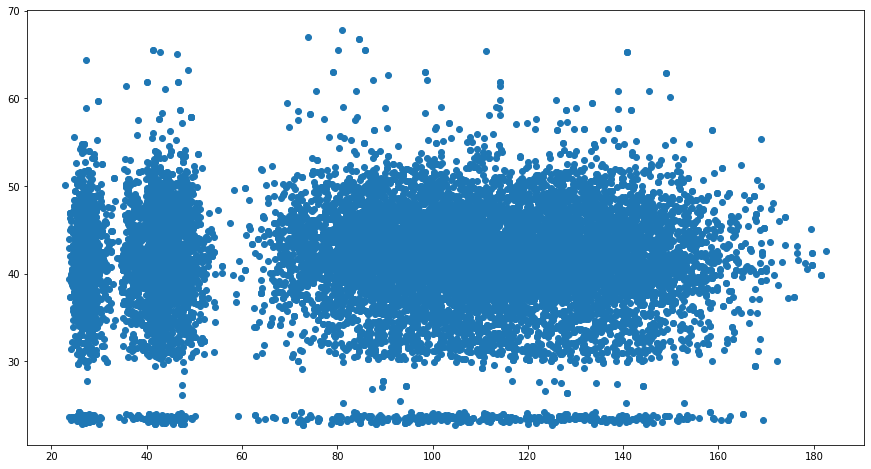

In [149]:
print(dfrender['powerDrawWatt_x'].corr(dfrender['timediff']))
plt.scatter(dfrender['powerDrawWatt_x'],dfrender['timediff'])

0.03970412776614891


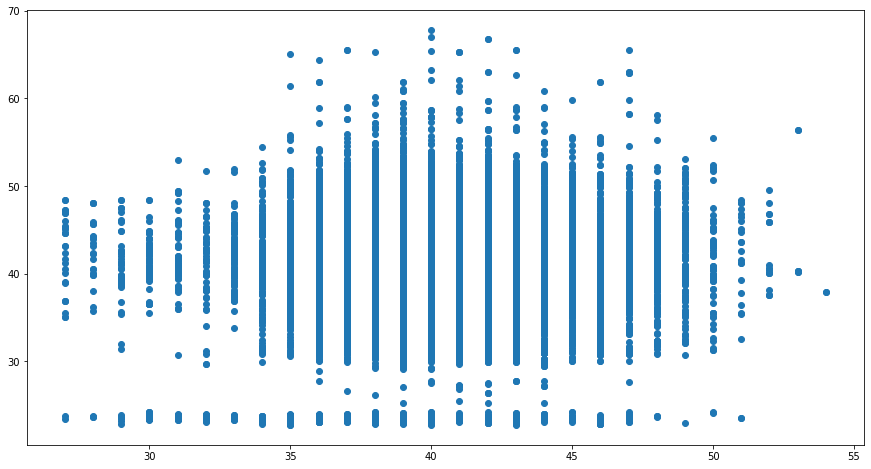

In [150]:
print(dfrender['gpuTempC_x'].corr(dfrender['timediff']))
plt.scatter(dfrender['gpuTempC_x'],dfrender['timediff'])

0.020095762606532414


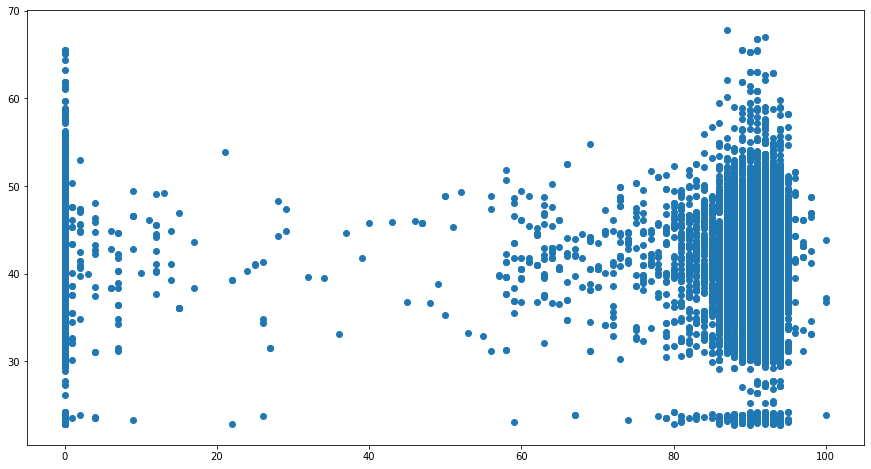

In [151]:
print(dfrender['gpuUtilPerc_x'].corr(dfrender['timediff']))
plt.scatter(dfrender['gpuUtilPerc_x'],dfrender['timediff'])

0.017096723765912362


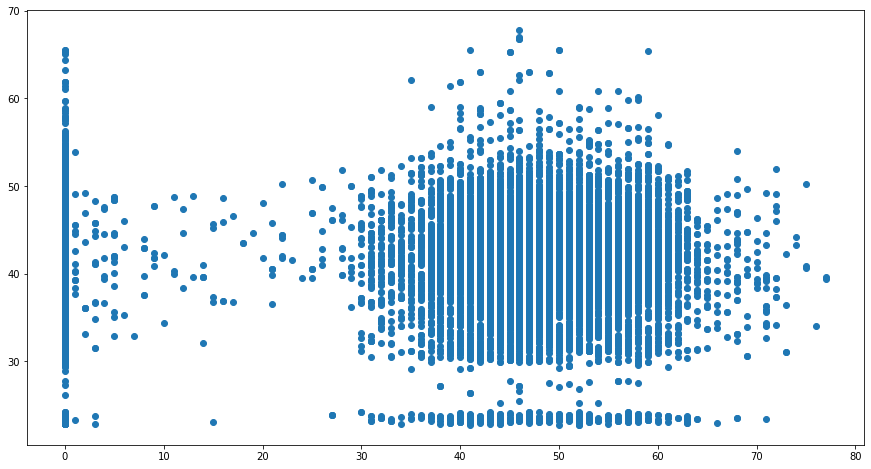

In [152]:
print(dfrender['gpuMemUtilPerc_x'].corr(dfrender['timediff']))
plt.scatter(dfrender['gpuMemUtilPerc_x'],dfrender['timediff'])

In [153]:
dfrender1=ps.sqldf('select avg(powerDrawWatt_x),	avg(gpuTempC_x), avg(gpuUtilPerc_x),	avg(gpuMemUtilPerc_x),avg(timediff) from dfrender group by eventName')
dfrender1

,avg(powerDrawWatt_x),avg(gpuTempC_x),avg(gpuUtilPerc_x),avg(gpuMemUtilPerc_x),avg(timediff)
0,91.307876,40.326308,64.990254,34.497505,41.27797


In [154]:
dfsavingconfig=ps.sqldf('select * from df3merge where eventName="Saving Config" ')
dfsavingconfig

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,hostname_y_x,eventName,eventType_x,jobId_x,taskId,timestamp_y,hostname_x_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,hostname_y_y,eventType_y,jobId_y,timediff
0,2018-11-08 08:27:10.574000,a77ef58b13ad4c01b769dac8409af3f800000Y,323617020164,GPU-d480204b-d0c9-1631-fd55-7ae42e6470cf,141.29,41,94,58,db871cd77a544e13bc791a64a0c8ed50000010,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8a8e3266-68dd-4ef1-b99a-b3e88ec9a970,2018-11-08 08:27:10.577000,4a79b6d2616049edbf06c6aa58ab426a000011,325217084713,GPU-45073596-b4bd-bb16-2ec4-12d5f8aeef44,42.64,37,0,0,db871cd77a544e13bc791a64a0c8ed50000010,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.003
1,2018-11-08 08:27:13.460000,265232c5f6814768aeefa66a7bec6ff600000S,323617043068,GPU-976b3bbd-fdea-ee53-615f-a98f28408299,125.99,44,94,53,4ad946d4435c42dabb5073531ea4f31500000J,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,34978715-109f-4c37-b28b-0aaeb4c54675,2018-11-08 08:27:13.462000,4c72fae95b9147189a0559269a6953ff000004,325017048867,GPU-cea5abe6-dfe8-d315-38f8-b691aad56a06,43.80,37,0,0,4ad946d4435c42dabb5073531ea4f31500000J,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.002
2,2018-11-08 08:27:13.460000,0745914f4de046078517041d70b22fe700000E,325017017790,GPU-769c04e0-4916-d031-0e0c-7d13fdde3e3d,39.31,35,0,0,4ad946d4435c42dabb5073531ea4f31500000J,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,34978715-109f-4c37-b28b-0aaeb4c54675,2018-11-08 08:27:13.462000,4c72fae95b9147189a0559269a6953ff000004,325017048867,GPU-cea5abe6-dfe8-d315-38f8-b691aad56a06,43.80,37,0,0,4ad946d4435c42dabb5073531ea4f31500000J,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.002
3,2018-11-08 08:27:13.460000,6139a35676de44d6b61ec247f0ed8657000019,320218055685,GPU-c5b20fb1-a8a2-3699-9def-2db4f6b0abc6,110.95,42,89,49,4ad946d4435c42dabb5073531ea4f31500000J,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,34978715-109f-4c37-b28b-0aaeb4c54675,2018-11-08 08:27:13.462000,4c72fae95b9147189a0559269a6953ff000004,325017048867,GPU-cea5abe6-dfe8-d315-38f8-b691aad56a06,43.80,37,0,0,4ad946d4435c42dabb5073531ea4f31500000J,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.002
4,2018-11-08 08:27:13.460000,95b4ae6d890e4c46986d91d7ac4bf08200000S,325217085955,GPU-019fdcd4-8840-a5d2-9bce-7e19077e0f6c,88.22,40,93,54,4ad946d4435c42dabb5073531ea4f31500000J,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,34978715-109f-4c37-b28b-0aaeb4c54675,2018-11-08 08:27:13.462000,4c72fae95b9147189a0559269a6953ff000004,325017048867,GPU-cea5abe6-dfe8-d315-38f8-b691aad56a06,43.80,37,0,0,4ad946d4435c42dabb5073531ea4f31500000J,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17487,2018-11-08 08:27:59.536000,95b4ae6d890e4c46986d91d7ac4bf082000019,325117172961,GPU-8ca429d5-d440-7df3-a699-c1e30e3fa476,114.35,41,91,54,0745914f4de046078517041d70b22fe7000010,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7c67641a-56ca-4ca7-a51e-789b33f1baed,2018-11-08 08:27:59.539000,5903af3699134795af7eafc605ae5fc7000012,325117172501,GPU-749afcd3-def7-dd5d-f0b6-04d45a81f31a,143.97,36,93,73,0745914f4de046078517041d70b22fe7000010,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.003
17488,2018-11-08 08:28:01.305000,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,124.66,38,93,57,4c72fae95b9147189a0559269a6953ff00000P,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1bbddbdf-ed50-4ee0-a82f-2ad4e2620aa9,2018-11-08 08:28:01.318000,db871cd77a544e13bc791a64a0c8ed5000000J,323617043151,GPU-964c6e6a-4c2b-d843-f187-46d526151dfe,119.40,45,93,54,4c72fae95b9147189a0559269a6953ff00000P,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f74770

In [155]:
summary=dfsavingconfig.describe()

In [156]:
summary=summary.transpose()

In [157]:
summary.head()

,count,mean,std,min,25%,50%,75%,max
gpuSerial_x,17492.0,3.239910e+11,1.189279e+09,3.201181e+11,3.236170e+11,3.236170e+11,3.250170e+11,3.252171e+11
powerDrawWatt_x,17492.0,9.182886e+01,3.881953e+01,2.322000e+01,4.751500e+01,9.890000e+01,1.228200e+02,1.923500e+02
gpuTempC_x,17492.0,4.041882e+01,3.615865e+00,2.600000e+01,3.800000e+01,4.000000e+01,4.200000e+01,5.400000e+01
gpuUtilPerc_x,17492.0,6.567448e+01,4.022557e+01,0.000000e+00,0.000000e+00,9.000000e+01,9.200000e+01,1.000000e+02
gpuMemUtilPerc_x,17492.0,3.496353e+01,2.247056e+01,0.000000e+00,0.000000e+00,4.400000e+01,5.100000e+01,7.600000e+01


In [158]:
correlation_matrix=dfsavingconfig.corr()
round(correlation_matrix,2)

,gpuSerial_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,gpuSerial_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,timediff
gpuSerial_x,1.00,-0.02,-0.17,-0.01,-0.00,-0.01,0.01,0.02,0.02,0.02,-0.00
powerDrawWatt_x,-0.02,1.00,0.49,0.85,0.86,-0.01,0.06,0.08,0.05,0.05,0.00
gpuTempC_x,-0.17,0.49,1.00,0.45,0.44,0.00,0.09,0.16,0.08,0.08,0.01
gpuUtilPerc_x,-0.01,0.85,0.45,1.00,0.96,-0.01,0.06,0.08,0.05,0.05,-0.00
gpuMemUtilPerc_x,-0.00,0.86,0.44,0.96,1.00,-0.01,0.06,0.08,0.05,0.05,-0.00
gpuSerial_y,-0.01,-0.01,0.00,-0.01,-0.01,1.00,-0.01,-0.16,0.01,0.01,-0.01
powerDrawWatt_y,0.01,0.06,0.09,0.06,0.06,-0.01,1.00,0.50,0.85,0.86,0.01
gpuTempC_y,0.02,0.08,0.16,0.08,0.08,-0.16,0.50,1.00,0.47,0.45,0.01
gpuUtilPerc_y,0.02,0.05,0.08,0.05,0.05,0.01,0.85,0.47,1.00,0.96,0.01
gpuMemUtilPerc_y,0.02,0.05,0.08,0.05,0.05,0.01,0.86,0.45,0.96,1.00,0.01


-0.002827758702542964


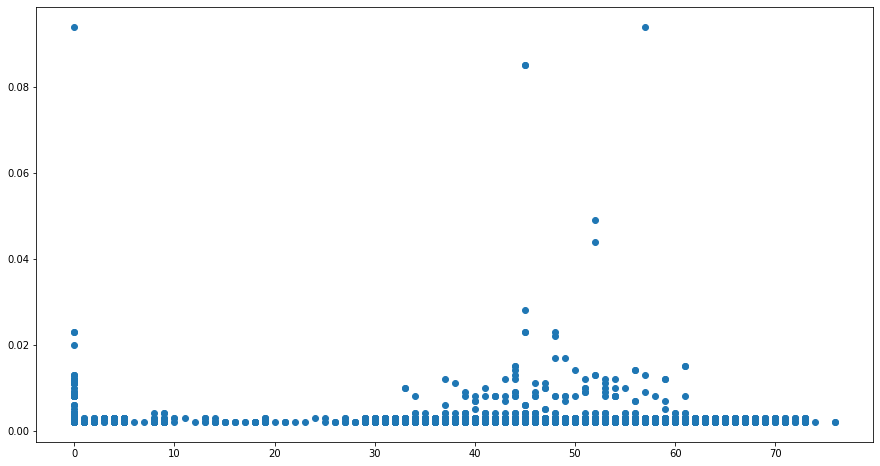

In [159]:
print(dfsavingconfig['gpuMemUtilPerc_x'].corr(dfsavingconfig['timediff']))
plt.scatter(dfsavingconfig['gpuMemUtilPerc_x'],dfsavingconfig['timediff'])

-0.003939959109769067


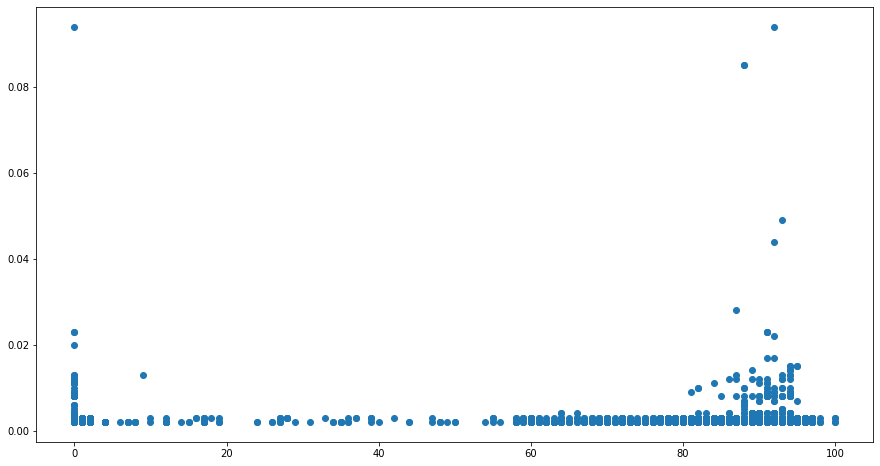

In [160]:
print(dfsavingconfig['gpuUtilPerc_x'].corr(dfsavingconfig['timediff']))
plt.scatter(dfsavingconfig['gpuUtilPerc_x'],dfsavingconfig['timediff'])

0.01349580814425461


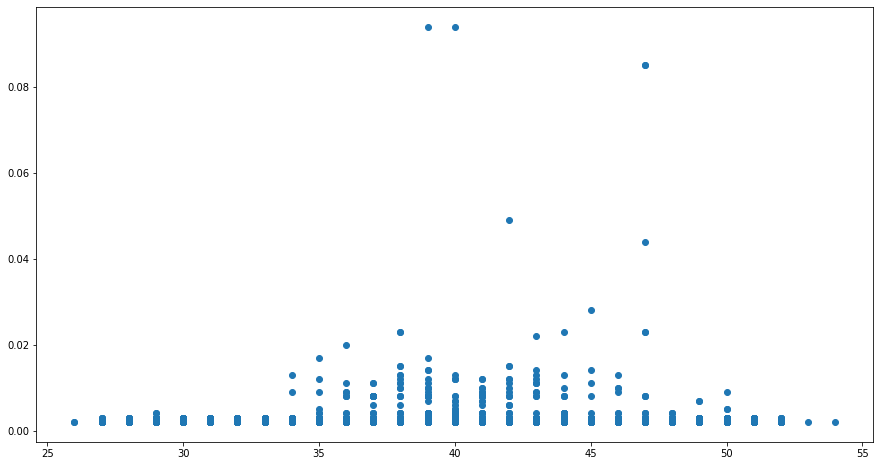

In [161]:
print(dfsavingconfig['gpuTempC_x'].corr(dfsavingconfig['timediff']))
plt.scatter(dfsavingconfig['gpuTempC_x'],dfsavingconfig['timediff'])

7.148486774412675e-05


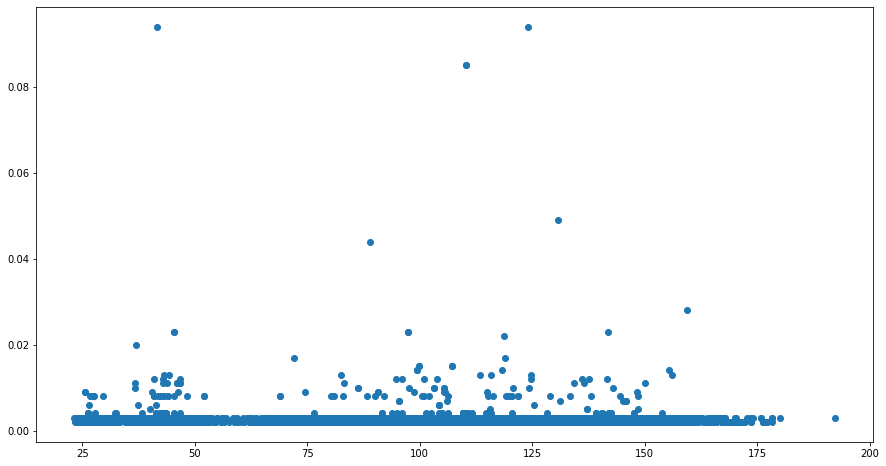

In [162]:
print(dfsavingconfig['powerDrawWatt_x'].corr(dfsavingconfig['timediff']))
plt.scatter(dfsavingconfig['powerDrawWatt_x'],dfsavingconfig['timediff'])

In [163]:
# dfsavingconfig1=ps.sqldf('select avg(powerDrawWatt),	avg(gpuTempC), avg(gpuUtilPerc),	avg(gpuMemUtilPerc)	 from dfsavingconfig group by eventName')
# dfsavingconfig1

In [164]:
dftiling=ps.sqldf('select * from df3merge where eventName="Tiling" ')
dftiling

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,hostname_y_x,eventName,eventType_x,jobId_x,taskId,timestamp_y,hostname_x_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,hostname_y_y,eventType_y,jobId_y,timediff
0,2018-11-08 08:27:07.855000,5903af3699134795af7eafc605ae5fc7000014,325017020245,GPU-a7e39f02-521d-647e-a02e-64b49a138e50,49.81,40,0,0,b9a1fa7ae2f74eb68f25f607980f97d700000Z,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,55423784-28a8-44ab-972a-46d87b280206,2018-11-08 08:27:08.901000,265232c5f6814768aeefa66a7bec6ff600000O,323617020120,GPU-b7e2dffb-a8da-83e5-686e-ef892e27409d,125.78,42,93,43,b9a1fa7ae2f74eb68f25f607980f97d700000Z,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.046
1,2018-11-08 08:27:07.855000,5903af3699134795af7eafc605ae5fc7000014,325017020245,GPU-a7e39f02-521d-647e-a02e-64b49a138e50,49.81,40,0,0,b9a1fa7ae2f74eb68f25f607980f97d700000Z,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,55423784-28a8-44ab-972a-46d87b280206,2018-11-08 08:27:08.901000,db871cd77a544e13bc791a64a0c8ed50000001,323617020154,GPU-f82c7dc3-ae8e-9c24-0913-eb90c977e686,41.38,38,2,0,b9a1fa7ae2f74eb68f25f607980f97d700000Z,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.046
2,2018-11-08 08:27:07.855000,0d56a730076643d585f77e00d2d8521a00000B,325017017512,GPU-971d7d26-9fb1-ab60-5180-75d82081d8cf,122.79,37,91,45,b9a1fa7ae2f74eb68f25f607980f97d700000Z,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,55423784-28a8-44ab-972a-46d87b280206,2018-11-08 08:27:08.901000,265232c5f6814768aeefa66a7bec6ff600000O,323617020120,GPU-b7e2dffb-a8da-83e5-686e-ef892e27409d,125.78,42,93,43,b9a1fa7ae2f74eb68f25f607980f97d700000Z,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.046
3,2018-11-08 08:27:07.855000,0d56a730076643d585f77e00d2d8521a00000B,325017017512,GPU-971d7d26-9fb1-ab60-5180-75d82081d8cf,122.79,37,91,45,b9a1fa7ae2f74eb68f25f607980f97d700000Z,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,55423784-28a8-44ab-972a-46d87b280206,2018-11-08 08:27:08.901000,db871cd77a544e13bc791a64a0c8ed50000001,323617020154,GPU-f82c7dc3-ae8e-9c24-0913-eb90c977e686,41.38,38,2,0,b9a1fa7ae2f74eb68f25f607980f97d700000Z,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.046
4,2018-11-08 08:27:13.845000,83ea61ac1ef54f27a3bf7bd0f41ecaa7000018,323617021519,GPU-0d5cec28-4daf-bab0-b4e8-2e53a81b48b1,97.67,43,92,46,b9a1fa7ae2f74eb68f25f607980f97d7000009,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,e76ac902-ed0e-40b4-987c-8c71a876edac,2018-11-08 08:27:14.970000,db871cd77a544e13bc791a64a0c8ed50000003,323217056464,GPU-2d4eed64-4ca8-f12c-24bc-28f036493ea2,26.12,37,0,0,b9a1fa7ae2f74eb68f25f607980f97d7000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17169,2018-11-08 08:27:49.802000,4ad946d4435c42dabb5073531ea4f315000016,320118119761,GPU-c03f9fc5-e123-f7d0-ba63-e406952669d0,48.17,37,0,0,95b4ae6d890e4c46986d91d7ac4bf082000009,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,ee8725d6-786f-4d5a-82fe-c283e61748a7,2018-11-08 08:27:50.781000,d8241877cd994572b46c861e5d144c8500001C,323617020369,GPU-ea11c851-c572-00cb-35dc-43076715b198,104.84,43,88,35,95b4ae6d890e4c46986d91d7ac4bf082000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.979
17170,2018-11-08 08:27:57.831000,a77ef58b13ad4c01b769dac8409af3f800000N,323217056029,GPU-50c55268-e212-7e5f-a682-00b66c46dc14,72.30,41,90,42,d8241877cd994572b46c861e5d144c8500000F,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,5ff7cf8c-dab4-4a83-b826-a9de1b7f0ed2,2018-11-08 08:27:58.764000,e7adc42d28814e518e9601ac2329c513000004,325217085332,GPU-d856c0d9-2c0c-32a4-1e08-600cdea6fca5,85.75,40,85,39,d8241877cd994572b46c861e5d144c8500000F,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.933
17171,2018-11-08 08:28:02.852000,d8241877cd

In [165]:
correlation_matrix=dftiling.corr()
round(correlation_matrix,2)

,gpuSerial_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,gpuSerial_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,timediff
gpuSerial_x,1.00,-0.01,-0.16,0.01,0.01,0.01,-0.01,-0.00,-0.01,-0.01,-0.01
powerDrawWatt_x,-0.01,1.00,0.48,0.85,0.86,0.00,0.01,0.03,0.02,0.02,0.00
gpuTempC_x,-0.16,0.48,1.00,0.45,0.43,0.00,0.03,0.06,0.03,0.03,0.03
gpuUtilPerc_x,0.01,0.85,0.45,1.00,0.96,0.00,0.02,0.03,0.02,0.02,0.00
gpuMemUtilPerc_x,0.01,0.86,0.43,0.96,1.00,0.00,0.02,0.03,0.02,0.02,0.01
gpuSerial_y,0.01,0.00,0.00,0.00,0.00,1.00,-0.00,-0.15,0.02,0.02,0.01
powerDrawWatt_y,-0.01,0.01,0.03,0.02,0.02,-0.00,1.00,0.47,0.84,0.86,0.01
gpuTempC_y,-0.00,0.03,0.06,0.03,0.03,-0.15,0.47,1.00,0.43,0.43,0.02
gpuUtilPerc_y,-0.01,0.02,0.03,0.02,0.02,0.02,0.84,0.43,1.00,0.96,0.01
gpuMemUtilPerc_y,-0.01,0.02,0.03,0.02,0.02,0.02,0.86,0.43,0.96,1.00,0.02


0.007008263809843065


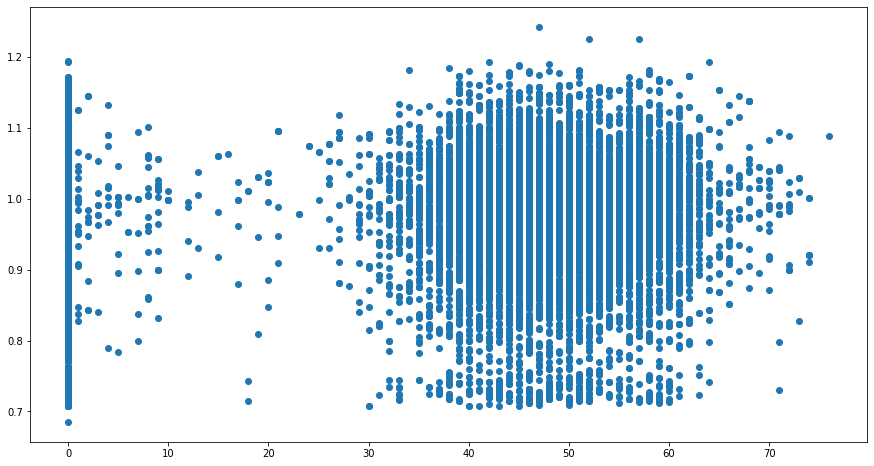

In [166]:
print(dftiling['gpuMemUtilPerc_x'].corr(dftiling['timediff']))
plt.scatter(dftiling['gpuMemUtilPerc_x'],dftiling['timediff'])

0.0030209215482463864


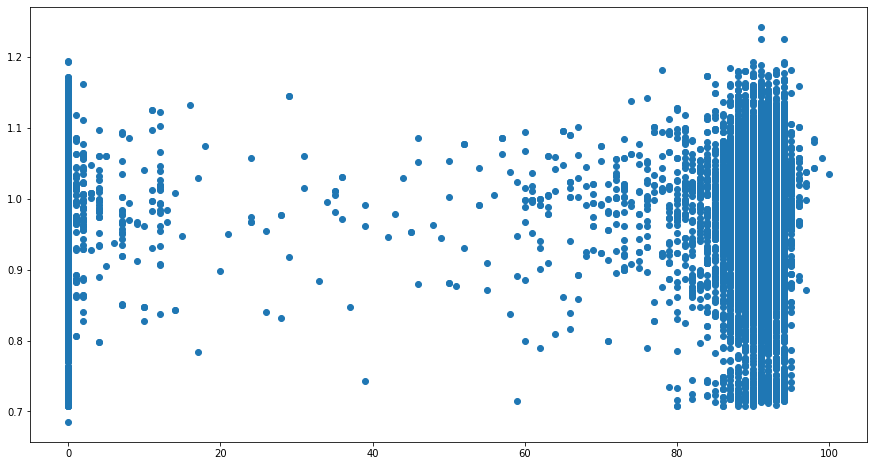

In [167]:
print(dftiling['gpuUtilPerc_x'].corr(dftiling['timediff']))
plt.scatter(dftiling['gpuUtilPerc_x'],dftiling['timediff'])

0.028906763438730738


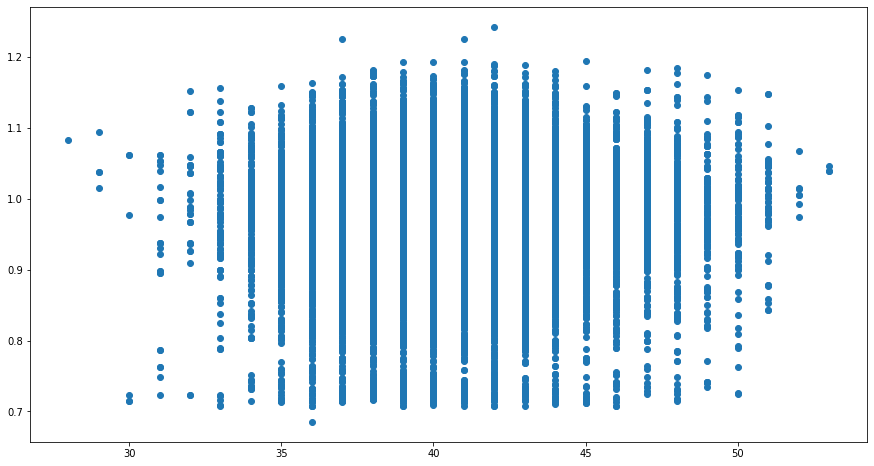

In [168]:
print(dftiling['gpuTempC_x'].corr(dftiling['timediff']))
plt.scatter(dftiling['gpuTempC_x'],dftiling['timediff'])

0.004981138467593851


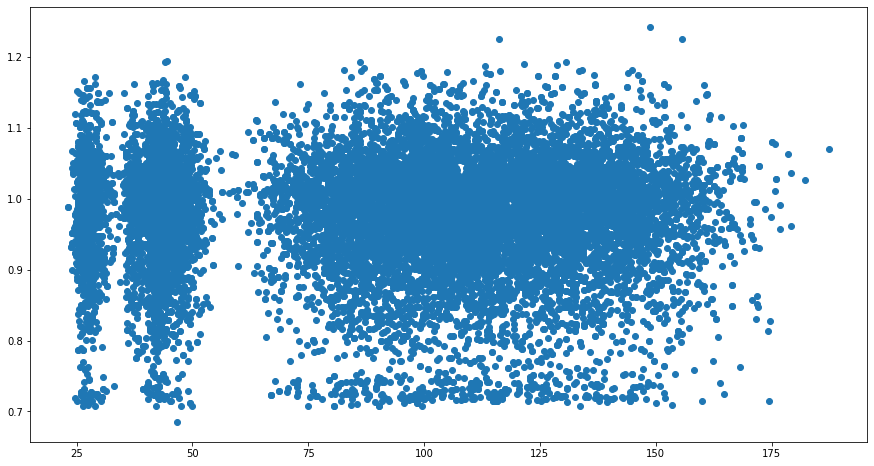

In [169]:
print(dftiling['powerDrawWatt_x'].corr(dftiling['timediff']))
plt.scatter(dftiling['powerDrawWatt_x'],dftiling['timediff'])

In [170]:
dftiling1=ps.sqldf('select avg(powerDrawWatt_x),	avg(gpuTempC_x), avg(gpuUtilPerc_x),	avg(gpuMemUtilPerc_x)	 from dftiling group by eventName')
dftiling1

,avg(powerDrawWatt_x),avg(gpuTempC_x),avg(gpuUtilPerc_x),avg(gpuMemUtilPerc_x)
0,92.071739,40.531967,65.994177,34.988995


In [171]:
dfuploading=ps.sqldf('select * from df3merge where eventName="Uploading" ')
dfuploading

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,hostname_y_x,eventName,eventType_x,jobId_x,taskId,timestamp_y,hostname_x_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,hostname_y_y,eventType_y,jobId_y,timediff
0,2018-11-08 08:27:10.875000,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af,2018-11-08 08:27:11.996000,95b4ae6d890e4c46986d91d7ac4bf08200000T,324917052614,GPU-bc05182a-0194-740f-827e-851d9ae28136,40.97,35,0,0,265232c5f6814768aeefa66a7bec6ff6000010,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.121
1,2018-11-08 08:27:10.359000,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,2018-11-08 08:27:11.391000,04dc4e9647154250beeee51b866b071500001C,323617020155,GPU-51b7ec74-a5ac-06b7-1fd0-9c11ce579ffc,28.05,39,0,0,6139a35676de44d6b61ec247f0ed8657000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.032
2,2018-11-08 08:27:10.359000,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,2018-11-08 08:27:11.391000,b9a1fa7ae2f74eb68f25f607980f97d7000012,325117172395,GPU-50f23433-71f3-6f16-3c86-0de884dc7493,44.21,37,0,0,6139a35676de44d6b61ec247f0ed8657000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.032
3,2018-11-08 08:27:15.057000,dcc19f48bb3445a28338db3a8f002e9c00000Y,323617020762,GPU-48504260-2b36-e796-830a-8dc7b9ab851a,102.97,42,89,42,a77ef58b13ad4c01b769dac8409af3f8000015,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,98ba792b-ab4f-44f1-a3fe-6dd2e770723e,2018-11-08 08:27:15.977000,cd44f5819eba427a816e7ce648adceb200001B,323217049007,GPU-72429cfd-57a1-129b-9615-9045cc682ee9,151.70,45,91,46,a77ef58b13ad4c01b769dac8409af3f8000015,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.920
4,2018-11-08 08:27:15.883000,4c72fae95b9147189a0559269a6953ff00000V,325017049278,GPU-0c038861-d224-604e-f31b-e6b0fef9b6f3,106.59,42,90,44,4c72fae95b9147189a0559269a6953ff000007,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,d968d511-49bf-4c0b-a2ab-c40f15b89c06,2018-11-08 08:27:16.822000,e7adc42d28814e518e9601ac2329c513000017,325117062966,GPU-3c1412e7-4c3c-aa4c-329a-776ba672aece,147.12,39,91,50,4c72fae95b9147189a0559269a6953ff000007,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17453,2018-11-08 08:28:00.053000,8b6a0eebc87b4cb2b0539e81075191b9000013,323217056452,GPU-be873659-353f-954b-9866-a24c951bab0c,112.34,46,89,40,95b4ae6d890e4c46986d91d7ac4bf08200000A,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b3a1edf4-5139-4a7f-9fe1-48cbe08cee4f,2018-11-08 08:28:01.214000,4c72fae95b9147189a0559269a6953ff000008,320118118866,GPU-cb946eab-ad72-d047-a11e-cc58ab19abe5,116.22,41,88,38,95b4ae6d890e4c46986d91d7ac4bf08200000A,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.161
17454,2018-11-08 08:27:58.987000,a77ef58b13ad4c01b769dac8409af3f800000Y,323617020164,GPU-d480204b-d0c9-1631-fd55-7ae42e6470cf,101.52,40,89,42,265232c5f6814768aeefa66a7bec6ff600000L,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,fd0c3c22-4f0f-4a0d-8c31-d26a87fdc5f9,2018-11-08 08:28:00.252000,4c72fae95b9147189a0559269a6953ff00000V,325017049278,GPU-0c038861-d224-604e-f31b-e6b0fef9b6f3,61.78,40,90,60,265232c5f6814768aeefa66a7bec6ff600000L,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.265
17455,2018-1

In [172]:
correlation_matrix=dfuploading.corr()
round(correlation_matrix,2)

,gpuSerial_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,gpuSerial_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,timediff
gpuSerial_x,1.00,-0.04,-0.18,-0.02,-0.02,0.00,0.00,-0.02,0.00,0.01,0.00
powerDrawWatt_x,-0.04,1.00,0.48,0.85,0.85,0.00,0.04,0.04,0.04,0.04,-0.07
gpuTempC_x,-0.18,0.48,1.00,0.45,0.44,0.00,0.05,0.07,0.04,0.04,-0.14
gpuUtilPerc_x,-0.02,0.85,0.45,1.00,0.96,0.00,0.03,0.03,0.04,0.03,-0.05
gpuMemUtilPerc_x,-0.02,0.85,0.44,0.96,1.00,0.01,0.03,0.03,0.03,0.03,-0.05
gpuSerial_y,0.00,0.00,0.00,0.00,0.01,1.00,-0.01,-0.15,0.00,0.00,-0.02
powerDrawWatt_y,0.00,0.04,0.05,0.03,0.03,-0.01,1.00,0.48,0.85,0.85,-0.11
gpuTempC_y,-0.02,0.04,0.07,0.03,0.03,-0.15,0.48,1.00,0.46,0.44,-0.17
gpuUtilPerc_y,0.00,0.04,0.04,0.04,0.03,0.00,0.85,0.46,1.00,0.96,-0.11
gpuMemUtilPerc_y,0.01,0.04,0.04,0.03,0.03,0.00,0.85,0.44,0.96,1.00,-0.11


-0.05001497044371302


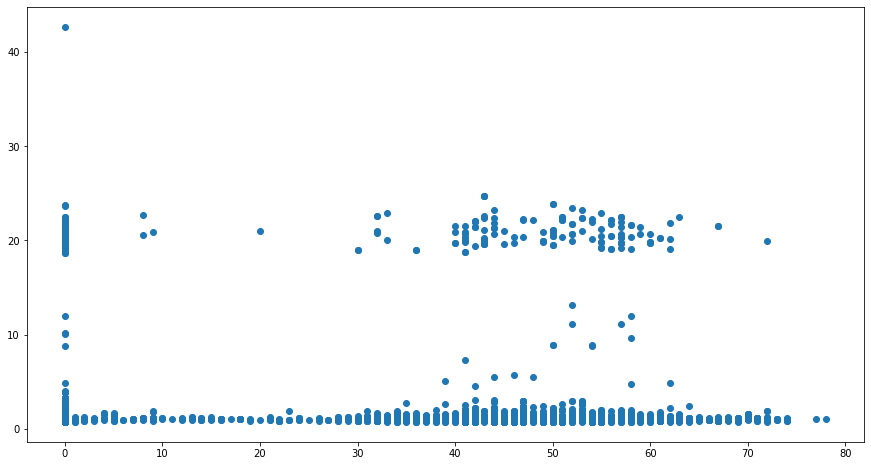

In [173]:
print(dfuploading['gpuMemUtilPerc_x'].corr(dfuploading['timediff']))
plt.scatter(dfuploading['gpuMemUtilPerc_x'],dfuploading['timediff'])

-0.054184835287796655


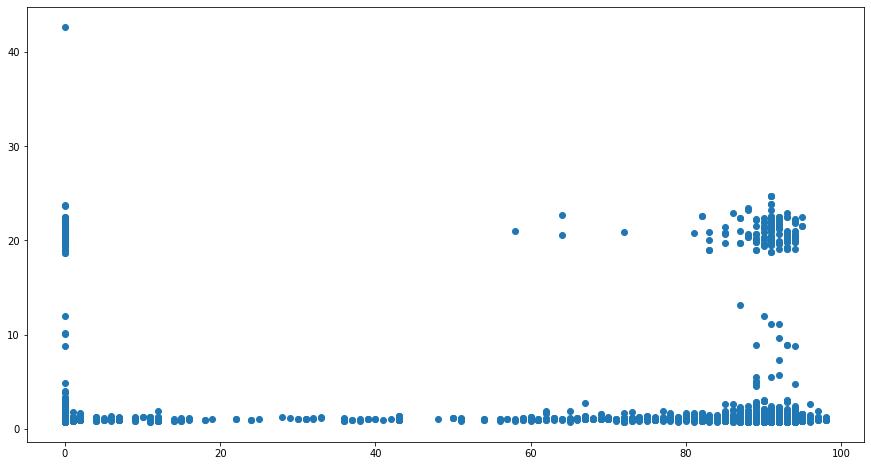

In [174]:
print(dfuploading['gpuUtilPerc_x'].corr(dfuploading['timediff']))
plt.scatter(dfuploading['gpuUtilPerc_x'],dfuploading['timediff'])

-0.1350483028249642


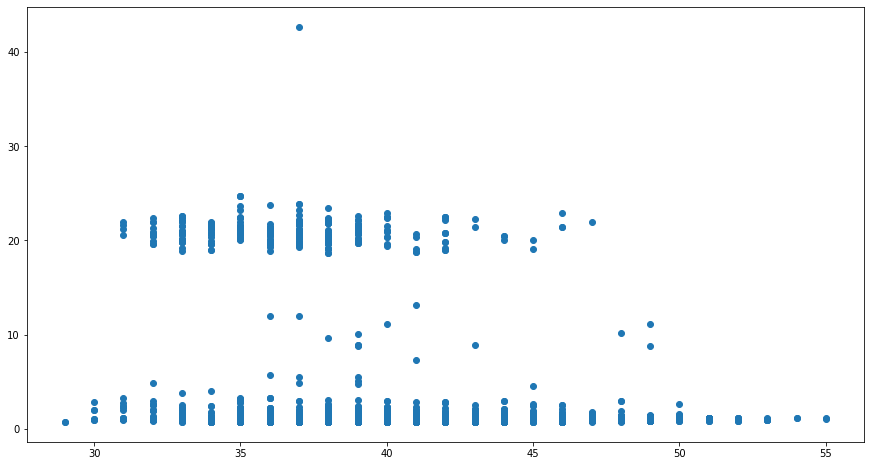

In [175]:
print(dfuploading['gpuTempC_x'].corr(dfuploading['timediff']))
plt.scatter(dfuploading['gpuTempC_x'],dfuploading['timediff'])

-0.06511976999920151


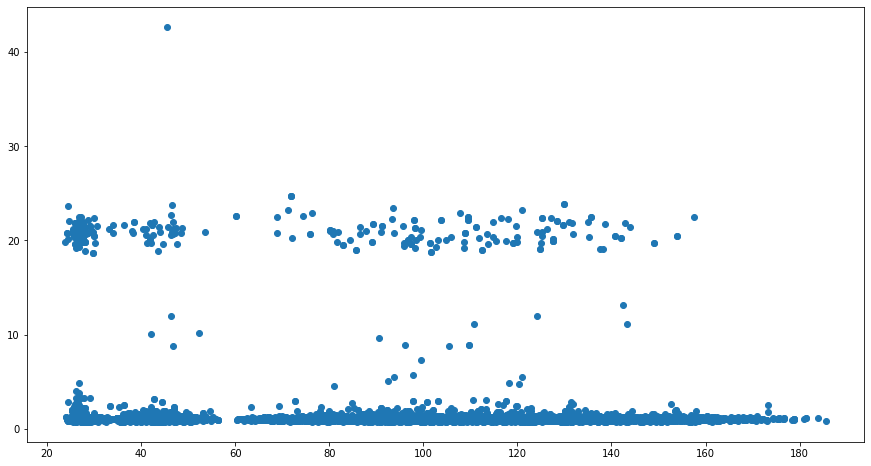

In [176]:
print(dfuploading['powerDrawWatt_x'].corr(dfuploading['timediff']))
plt.scatter(dfuploading['powerDrawWatt_x'],dfuploading['timediff'])

In [177]:
dfuploading1=ps.sqldf('select avg(powerDrawWatt_x),	avg(gpuTempC_x), avg(gpuUtilPerc_x),	avg(gpuMemUtilPerc_x)	 from dfuploading group by eventName')
dfuploading1

,avg(powerDrawWatt_x),avg(gpuTempC_x),avg(gpuUtilPerc_x),avg(gpuMemUtilPerc_x)
0,91.572035,40.449708,65.517413,34.740807


In [178]:
dfgpu= ps.sqldf('select gpuSerial_x ,avg(timediff) as average_time, avg(gpuUtilPerc_x) as average_utilization from df3merge  where eventName="TotalRender" group by gpuSerial_x')
dfgpu['average_performance']=dfgpu['average_utilization']/dfgpu['average_time']
dfgpu=ps.sqldf('select * from dfgpu order by average_performance')
dfgpu

,gpuSerial_x,average_time,average_utilization,average_performance
0,323617021537,46.448353,20.882353,0.449582
1,323617021323,36.365667,18.533333,0.509638
2,323617020887,44.364900,26.700000,0.601827
3,323617043132,48.658238,29.428571,0.604801
4,323617020087,36.809625,22.750000,0.618045
...,...,...,...,...
1019,323617042614,37.939286,86.285714,2.274310
1020,323217056299,35.101818,82.818182,2.359370
1021,320118119725,38.729636,92.272727,2.382484
1022,320118118790,38.541444,92.444444,2.398572


In [179]:
dfgpu1= ps.sqldf('select * from dfgpu where average_performance<=1')

In [180]:
dfgpu1

,gpuSerial_x,average_time,average_utilization,average_performance
0,323617021537,46.448353,20.882353,0.449582
1,323617021323,36.365667,18.533333,0.509638
2,323617020887,44.364900,26.700000,0.601827
3,323617043132,48.658238,29.428571,0.604801
4,323617020087,36.809625,22.750000,0.618045
5,323617020264,41.101222,25.444444,0.619068
6,323617021475,41.200600,29.533333,0.716818
7,325217084598,43.027750,32.937500,0.765494
8,325017020198,41.925500,33.000000,0.787110
9,323217056304,41.969688,33.375000,0.795217


As the average performance of these is close to 0. these are the serial number of worst performing cards. these have been calculated on the basis of average utilization per unit time. so that it can return an unbiased value for same task that is **Total Render**.

In [181]:
df5=ps.sqldf('select * from df5 where eventName="TotalRender"')

In [182]:
df5.drop_duplicates()

,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,eventName,taskId,timediff,jobId,x,y,level
0,119.85,38,92,52,TotalRender,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,44.736,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,248,255,12
2,105.08,40,91,44,TotalRender,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,44.736,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,248,255,12
4,124.88,43,93,52,TotalRender,59f756d6-2e27-4c33-b44e-28aac785da46,42.430,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,186,14,12
5,140.29,41,89,46,TotalRender,59f756d6-2e27-4c33-b44e-28aac785da46,42.430,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,186,14,12
6,90.95,45,92,44,TotalRender,da7fc9b5-d485-42eb-8207-1ed95d9545f3,47.729,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,107,95,12
...,...,...,...,...,...,...,...,...,...,...,...
17470,27.47,38,0,0,TotalRender,995d840e-6fc8-437f-992a-020d27fa3a78,49.570,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,188,163,12
17472,137.46,40,94,57,TotalRender,c01ab173-2b8a-4c80-9dff-eaf470a5cd68,41.535,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,17,127,12
17473,79.00,36,92,57,TotalRender,b000c9e1-ebc6-4276-a0dc-85b31beb434b,38.632,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,43,193,12
17474,47.60,41,0,0,TotalRender,436cce16-2783-477c-996f-068a3ba2b129,37.713,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,93,230,12


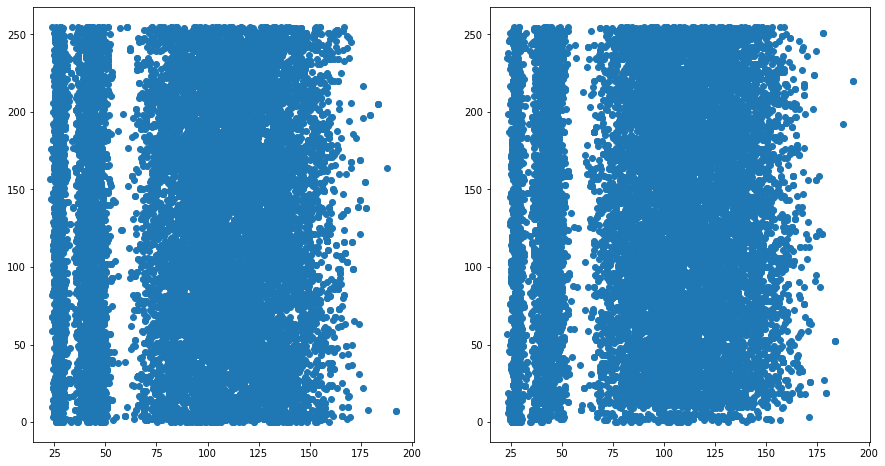

In [185]:
x=df5.x
y=df5.y

plt.subplot(1,2,1)
plt.scatter(df5.powerDrawWatt_x,x)
plt.subplot(1,2,2)
plt.scatter(df5.powerDrawWatt_x,y)

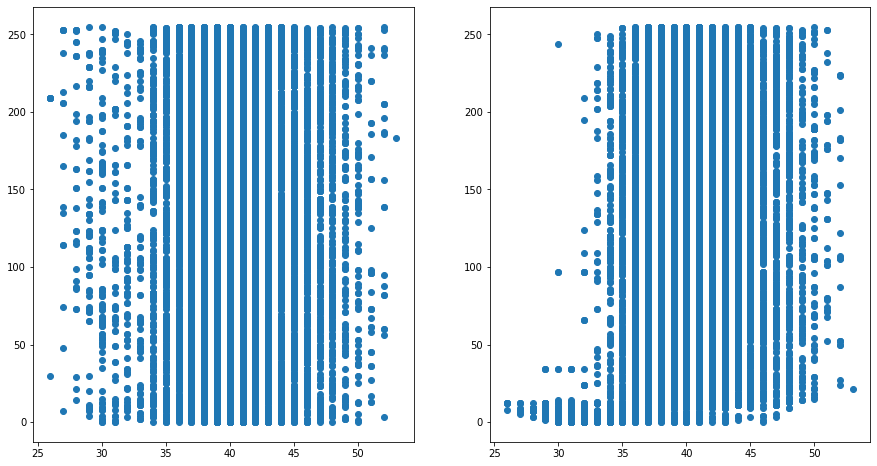

In [198]:
x=df5.x
y=df5.y

plt.subplot(1,2,1)
plt.scatter(df5.gpuTempC_x,x)
plt.subplot(1,2,2)
plt.scatter(df5.gpuTempC_x,y)

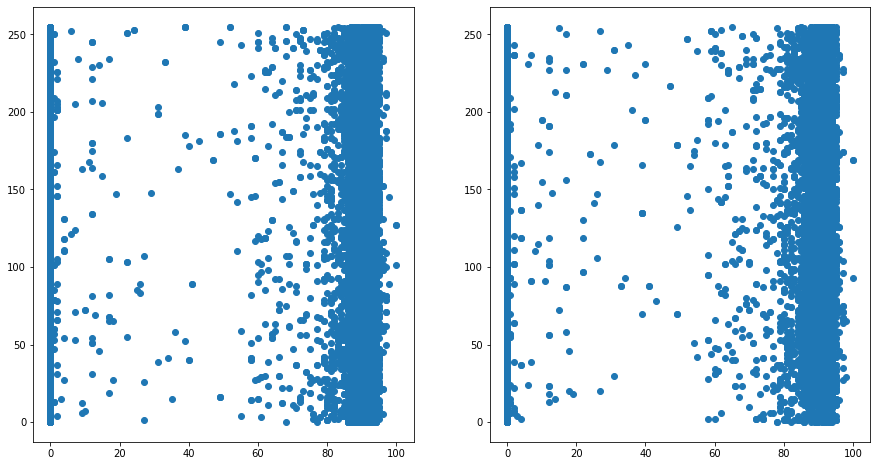

In [199]:
x=df5.x
y=df5.y

plt.subplot(1,2,1)
plt.scatter(df5.gpuUtilPerc_x,x)
plt.subplot(1,2,2)
plt.scatter(df5.gpuUtilPerc_x,y)

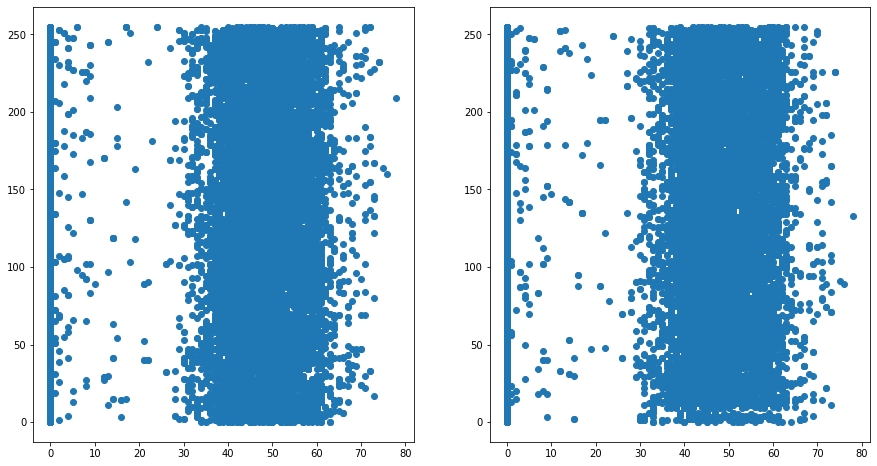

In [200]:
x=df5.x
y=df5.y

plt.subplot(1,2,1)
plt.scatter(df5.gpuMemUtilPerc_x,x)
plt.subplot(1,2,2)
plt.scatter(df5.gpuMemUtilPerc_x,y)

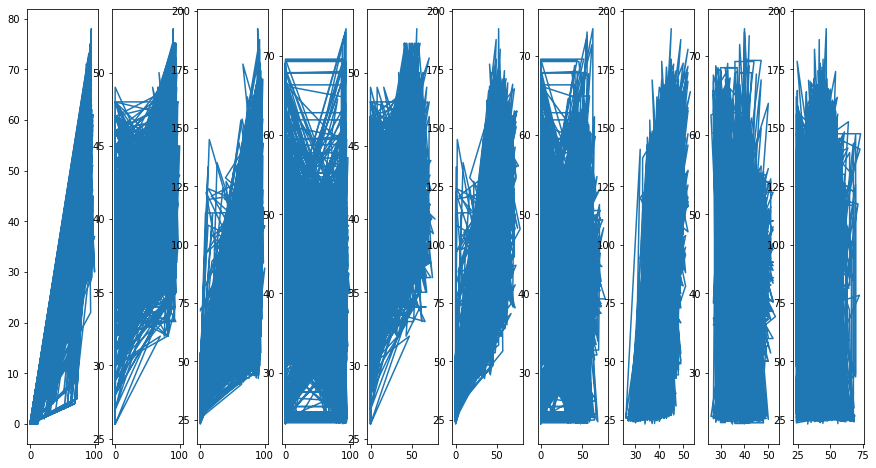

In [206]:
plt.subplot(1,10,1)
plt.plot(df5.gpuUtilPerc_x,df5.gpuMemUtilPerc_x)
plt.subplot(1,10,2)
plt.plot(df5.gpuUtilPerc_x,df5.gpuTempC_x)
plt.subplot(1,10,3)
plt.plot(df5.gpuUtilPerc_x,df5.powerDrawWatt_x)
plt.subplot(1,10,4)
plt.plot(df5.gpuUtilPerc_x,df5.timediff)
plt.subplot(1,10,5)
plt.plot(df5.gpuMemUtilPerc_x,df5.gpuTempC_x)
plt.subplot(1,10,6)
plt.plot(df5.gpuMemUtilPerc_x,df5.powerDrawWatt_x)
plt.subplot(1,10,7)
plt.plot(df5.gpuMemUtilPerc_x,df5.timediff)
plt.subplot(1,10,8)
plt.plot(df5.gpuTempC_x,df5.powerDrawWatt_x)
plt.subplot(1,10,9)
plt.plot(df5.gpuTempC_x,df5.timediff)
plt.subplot(1,10,10)
plt.plot(df5.timediff,df5.powerDrawWatt_x)

In [203]:
correlation_matrix=df5.corr()
round(correlation_matrix,2)

,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,timediff,x,y,level
powerDrawWatt_x,1.00,0.50,0.85,0.86,-0.04,0.01,0.08,0.03
gpuTempC_x,0.50,1.00,0.47,0.45,-0.06,0.03,0.16,0.09
gpuUtilPerc_x,0.85,0.47,1.00,0.96,-0.04,0.01,0.08,0.03
gpuMemUtilPerc_x,0.86,0.45,0.96,1.00,-0.03,0.01,0.08,0.02
timediff,-0.04,-0.06,-0.04,-0.03,1.00,0.11,0.11,-0.05
x,0.01,0.03,0.01,0.01,0.11,1.00,0.00,0.10
y,0.08,0.16,0.08,0.08,0.11,0.00,1.00,0.10
level,0.03,0.09,0.03,0.02,-0.05,0.10,0.10,1.00
